FUZZY LOGIC ROBOTIC ARM CONTROLLER
Choose configuration:
1. Stable
2. Fast
3. Custom
Enter mode: 3
Enter target angle (degrees): 45
Enter initial angle (degrees): 0
Enter time step (e.g., 0.05): 0.05
Enter control gain (e.g., 1.2): 0.8
Enter max steps (e.g., 1000): 1500
Enter control saturation limit (e.g., 50.0): 20.0
Target: 45.0°, Initial: 0.0°
Parameters: dt=0.05, gain=0.8, sat=20.0

✅ Converged at step 183, time=9.15s
Final angle=44.482° (error=1.318°)


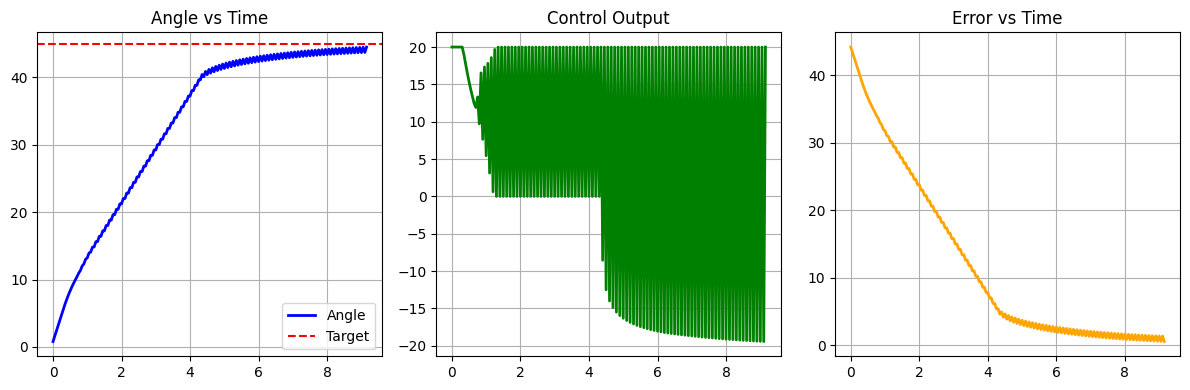

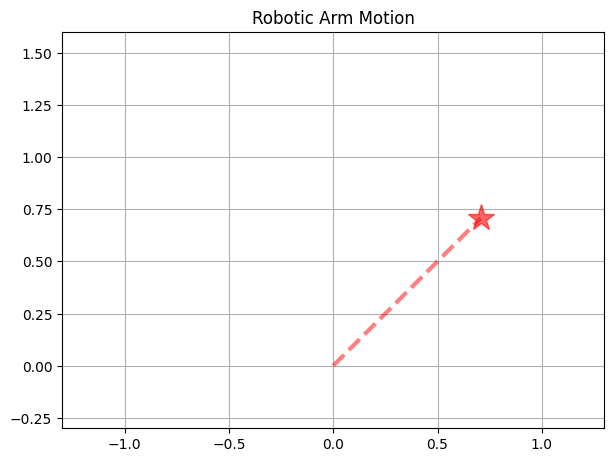

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# ---------- Triangular membership (vectorized) ----------
def trimf(x, a, b, c):
    x = np.asarray(x)
    result = np.zeros_like(x, dtype=float)
    result[(x > a) & (x < b)] = (x[(x > a) & (x < b)] - a) / (b - a)
    result[(x > b) & (x < c)] = (c - x[(x > b) & (x < c)]) / (c - b)
    result[x == b] = 1
    return result

# ---------- Presets ----------
print("=" * 50)
print("FUZZY LOGIC ROBOTIC ARM CONTROLLER")
print("=" * 50)
print("Choose configuration:\n1. Stable\n2. Fast\n3. Custom")
mode = int(input("Enter mode: "))

if mode == 1:
    target_angle, cur_angle, dt, gain, max_steps, control_sat = 45, 0, 0.05, 0.8, 1500, 30
elif mode == 2:
    target_angle, cur_angle, dt, gain, max_steps, control_sat = 45, 0, 0.04, 1.0, 1200, 35
else:
    target_angle = float(input("Enter target angle (degrees): "))
    cur_angle = float(input("Enter initial angle (degrees): "))
    dt = float(input("Enter time step (e.g., 0.05): "))
    gain = float(input("Enter control gain (e.g., 1.2): "))
    max_steps = int(input("Enter max steps (e.g., 1000): "))
    control_sat = float(input("Enter control saturation limit (e.g., 50.0): "))

print("=" * 50)
print(f"Target: {target_angle}°, Initial: {cur_angle}°")
print(f"Parameters: dt={dt}, gain={gain}, sat={control_sat}")

# ---------- Define fuzzy sets ----------
def err_large_neg(x): return trimf(x, -90, -60, -30)
def err_small_neg(x): return trimf(x, -40, -20, 0)
def err_zero(x): return trimf(x, -5, 0, 5)
def err_small_pos(x): return trimf(x, 0, 20, 40)
def err_large_pos(x): return trimf(x, 30, 60, 90)

def derr_neg(x): return trimf(x, -50, -25, 0)
def derr_zero(x): return trimf(x, -10, 0, 10)
def derr_pos(x): return trimf(x, 0, 25, 50)

u_universe = np.linspace(-50, 50, 1001)
def u_large_neg(x): return trimf(x, -50, -40, -25)
def u_small_neg(x): return trimf(x, -35, -20, -5)
def u_zero(x): return trimf(x, -8, 0, 8)
def u_small_pos(x): return trimf(x, 5, 20, 35)
def u_large_pos(x): return trimf(x, 25, 40, 50)

# ---------- Rule evaluation ----------
def evaluate_rules(e_val, de_val):
    e_ln, e_sn, e_z, e_sp, e_lp = err_large_neg(e_val), err_small_neg(e_val), err_zero(e_val), err_small_pos(e_val), err_large_pos(e_val)
    de_n, de_z, de_p = derr_neg(de_val), derr_zero(de_val), derr_pos(de_val)
    fired = []
    fired += [(min(e_ln, de_n), u_large_neg), (min(e_ln, de_z), u_large_neg), (min(e_ln, de_p), u_small_neg)]
    fired += [(min(e_sn, de_n), u_large_neg), (min(e_sn, de_z), u_small_neg), (min(e_sn, de_p), u_zero)]
    fired += [(min(e_z, de_n), u_small_neg), (min(e_z, de_z), u_zero), (min(e_z, de_p), u_small_pos)]
    fired += [(min(e_sp, de_n), u_zero), (min(e_sp, de_z), u_small_pos), (min(e_sp, de_p), u_large_pos)]
    fired += [(min(e_lp, de_n), u_small_pos), (min(e_lp, de_z), u_large_pos), (min(e_lp, de_p), u_large_pos)]
    return fired

# ---------- Defuzzify ----------
def defuzz_centroid(mf, universe):
    num, den = np.sum(mf * universe), np.sum(mf)
    return num / den if den > 1e-10 else 0.0

# ---------- Aggregate ----------
def aggregate(fired, universe):
    agg = np.zeros_like(universe)
    for strength, mf_func in fired:
        if strength > 0:
            agg = np.maximum(agg, np.minimum(strength, mf_func(universe)))
    return agg

# ---------- Simulation ----------
time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle
stable_steps = 0
tolerance = 1.5  # relaxed tolerance

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt
    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = np.clip(defuzz_centroid(agg, u_universe), -control_sat, control_sat)

    cur_angle += gain * u_out * dt
    prev_error = e
    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    if abs(e) < tolerance:
        stable_steps += 1
        if stable_steps > 15:
            print(f"\n✅ Converged at step {step}, time={step*dt:.2f}s")
            print(f"Final angle={cur_angle:.3f}° (error={e:.3f}°)")
            break
    else:
        stable_steps = 0
else:
    print(f"\n⚠️ Did not converge within max steps (Final angle={cur_angle:.3f}°, error={target_angle-cur_angle:.3f}°)")

# ---------- Plot ----------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(time_hist, angle_hist, 'b-', lw=2, label='Angle')
plt.axhline(target_angle, ls='--', c='r', label='Target')
plt.legend(); plt.title("Angle vs Time"); plt.grid(True)
plt.subplot(1,3,2)
plt.plot(time_hist, control_hist, 'g-', lw=2); plt.title("Control Output"); plt.grid(True)
plt.subplot(1,3,3)
errors = [target_angle - a for a in angle_hist]
plt.plot(time_hist, errors, 'orange', lw=2); plt.title("Error vs Time"); plt.grid(True)
plt.tight_layout(); plt.show()

# ---------- Animation ----------
fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(-1.3, 1.3); ax.set_ylim(-0.3, 1.6)
ax.set_aspect('equal'); ax.grid(True)
target_x, target_y = np.sin(np.radians(target_angle)), np.cos(np.radians(target_angle))
ax.plot([0, target_x], [0, target_y], 'r--', lw=3, alpha=0.5)
ax.plot(target_x, target_y, 'r*', ms=20, alpha=0.6)
arm_line, = ax.plot([], [], 'b-', lw=8)
arm_end, = ax.plot([], [], 'go', ms=12)

def init(): arm_line.set_data([], []); arm_end.set_data([], []); return arm_line, arm_end
def update(frame):
    a = angle_hist[frame]; x, y = np.sin(np.radians(a)), np.cos(np.radians(a))
    arm_line.set_data([0, x], [0, y]); arm_end.set_data([x], [y]); return arm_line, arm_end

ani = FuncAnimation(fig, update, frames=len(angle_hist), init_func=init, blit=True, interval=30)
plt.title("Robotic Arm Motion"); plt.show()
